Blending of stylegan3 and stylegan2 models with stylegan3 codebase.
Made by [Alex Spirin](https://twitter.com/devdef)

The idea of layer blending was inspired by [Justin Pinkney](https://twitter.com/Buntworthy) and his [stylegan blending example](https://github.com/justinpinkney/toonify/blob/master/StyleGAN-blending-example.ipynb)

If you like what I'm doing - check out my [Patreon page](https://www.patreon.com/sxela)

You will need your own fine-tuned stylegan models to blend with!

![visitors](https://visitor-badge.glitch.me/badge?page_id=sxela_stylegan3blending)

In [ ]:
#@title This colab is distributed under the MIT license
"""MIT License

Copyright (c) 2021 Alex Spirin

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE."""

In [1]:
!pip install ninja
%cd /content/
!git clone https://github.com/NVlabs/stylegan3
%cd /content/stylegan3/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 4.4 MB/s eta 0:00:00
/content
Cloning into 'stylegan3'...
remote: Enumerating objects: 207, done.
remote: Total 207 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (207/207), 4.17 MiB | 3.25 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/stylegan3


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#common functions
import pickle, torch, PIL, copy, cv2, math
import numpy as np

def get_model(path):
  with open(path, 'rb') as f:
    _G = pickle.load(f)['G_ema'].cuda()
  return _G

#tensor to PIL image 
def t2i(t):
  return PIL.Image.fromarray((t*127.5+127).clamp(0,255)[0].permute(1,2,0).cpu().numpy().astype('uint8'))

#stack an array of PIL images horizontally
def add_imgs(images):
  widths, heights = zip(*(i.size for i in images))

  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]
  return new_im


def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()
 
def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)
 
    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)
 
    return matrix

# A simple color correction script to brighten overly dark images
def simplest_cb(img, percent):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100
 
    half_percent = percent / 200.0
 
    channels = cv2.split(img)
 
    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)
 
        assert len(flat.shape) == 1
 
        flat = np.sort(flat)
 
        n_cols = flat.shape[0]
 
        low_val  = flat[math.floor(n_cols * half_percent)-1]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))-1]
 
 
        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)
 
    return cv2.merge(out_channels)
 
def normalize(inf, thresh):
    img = np.array(inf)
    out_img = simplest_cb(img, thresh)
    return PIL.Image.fromarray(out_img)


# Stylegan3 model blending

In [ ]:
#Download pretrained checkpoint
init_model = 'stylegan3-t-ffhqu-256x256.pkl'

!wget -P /content https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/{init_model}
net_raw = f'/content/{init_model}'
G = get_model(net_raw)

--2023-01-24 08:55:03--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhqu-256x256.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 52.53.73.145, 54.219.61.22
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|52.53.73.145|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/team/research/models/stylegan3/versions/1/files/stylegan3-t-ffhqu-256x256.pkl?response-content-disposition=attachment%3B%20filename%3D%22stylegan3-t-ffhqu-256x256.pkl%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEID%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLXdlc3QtMiJGMEQCIGnfwyzHH0QpVQtwZfGGUImMJV%2BA062zeL6mH77Gcdz2AiBb7qWhCa7KS6nQixm2hIws77t8rlVG7c4Hs4oH84qrcCrVBAjp%2F%2F%2F%2F%2F%2F%2F%2F%2F%2F8BEAQaDDc4OTM2MzEzNTAyNyIMsJZnV6aMhnVbnkF6KqkExESG1zSXZXDVP3b8%2BGmflXF7EcPSnqRv8tKDinQb2YtkIfj4UxiVtoonLW2AXek2yHX0CmfBoWa5Vyg

In [ ]:
#specify fine-tuned checkpoint and load both networks

net_tuned = '/content/drive/MyDrive/00000-stylegan3-t-ffhq-256x256-gpus1-batch16-gamma6.6/network-snapshot-000160.pkl'

%cd /content/stylegan3/
G_new = copy.deepcopy(G)
G_tuned = get_model(net_tuned)


/content/stylegan3


In [ ]:
# Blend based on layer number thresold. All layers before the threshold are taken from the init gen, all layers after the threshold - from the fine-tuned gen.
# If the layer name is bigger than the threshold, we take the fine-tuned gen layers, else init gen layers.
def doBlend(blend_thresh=7): 
  newDictSynt = G_tuned.synthesis.state_dict().copy()
  GSyntKeys = G.synthesis.state_dict().keys()

  for key in GSyntKeys:
    if key[:1]!='L': continue
    
    if int(key.split('_')[0][1:]) > blend_thresh: l = 1
    else: l = 0
    if 'affine' in key: l = 0

    newDictSynt[key] = newDictSynt[key]*l + G.synthesis.state_dict()[key]*(1-l)

  G_new.synthesis.load_state_dict(newDictSynt)

doBlend()

In [ ]:
#Blend using mask. Number of layers in stylegan3 depends on config and not on gen resolution, as it was with stylegan2.

# blend = [0,0,0,0,0,0,0,0.2,0.5,0.7,0.9,1,1,1,1]
# blend = [0,0,0,0,0,0,0,0.2,0.5,0.7,0.8,.8,.8,.8,.8]
blend = [0,0,0,0,0,0.2,0.2,0.2,0.5,0.7,0.8,.8,.8,.8,1]
# blend = [0]*7+[0.8]*(15-7)

# Not blending affine layers gives us colors closer to the original gen, without affecting the geometry much.
def doBlend(): 
  newDictSynt = G_tuned.synthesis.state_dict().copy()
  GSyntKeys = G.synthesis.state_dict().keys()

  for key in GSyntKeys:
    if key[:1]!='L': continue
    l = blend[int(key.split('_')[0][1:])]
    if 'affine' in key: l = 0
    newDictSynt[key] = newDictSynt[key]*l + G.synthesis.state_dict()[key]*(1-l)

  G_new.synthesis.load_state_dict(newDictSynt)

doBlend()

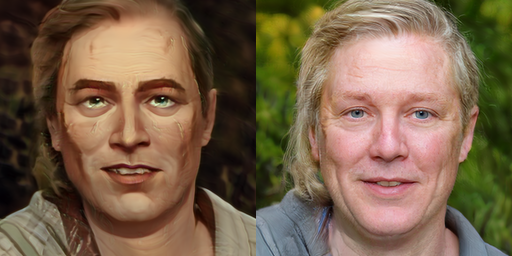

In [ ]:
# Pick a seed and blend threshold or blend mask. The image will be saved in /content/ folder.
# Init one of blend functions from above (I suggest the latter)
seed = 5
blend_thresh = 13
blend = [0,0,0,0,0,0.2,0.2,0.2,0.5,0.7,0.8,.8,.8,.8,1]
psi = 0.5

bl_str = ('_').join([str(o) for o in blend])
net = net_tuned.split('/')[-1]
rnd = np.random.RandomState(seed)
z = torch.tensor(rnd.randn(1,G.z_dim)).cuda()

doBlend()
w = G.mapping(z, None, truncation_psi=psi, truncation_cutoff=8)

im1 = G.synthesis(w, noise_mode='const', force_fp32=True)
im3 = G_new.synthesis(w, noise_mode='const', force_fp32=True)
im1 = t2i(im1)
im3 = t2i(im3)
im = add_imgs([im3,im1])
im.save(f'/content/m{net}_psi{psi}_b{bl_str}_s{seed}.jpg'); im

In [ ]:
#Generate image pairs 
from tqdm.notebook import trange
import os

out_dir = '/content/out/'
images = 100

os.makedirs(out_dir, exist_ok=True)
bl_str = ('_').join([str(o) for o in blend])
net = net_tuned.split('/')[-1]
blend_thresh = 7
blend = [0,0,0,0,0,0.2,0.2,0.2,0.5,0.7,0.8,.8,.8,.8,1]
psi = 0.5
doBlend()

for i in trange(images):
  seed =i

  rnd = np.random.RandomState(seed)
  z = torch.tensor(rnd.randn(1,G.z_dim)).cuda()
  w1 = G.mapping(z, None, truncation_psi=psi, truncation_cutoff=8)

  im1 = G.synthesis(w1, noise_mode='const', force_fp32=True)
  im2 = G_tuned.synthesis(w1, noise_mode='const', force_fp32=True)
  im3 = G_new.synthesis(w1, noise_mode='const', force_fp32=True)
  im1 = t2i(im1)
  im3 = t2i(im3)
  im = add_imgs([im3,im1])

  im.save(f'{out_dir}/b{bl_str}_s{seed}_m{net}.jpg')
#pack results
!zip -qq b{bl_str}_m{net}.zip {out_dir}/*

  0%|          | 0/100 [00:00<?, ?it/s]

# Stylegan 2 model blending (stylegan3 codebase)

In [4]:
import dnnlib
import legacy

In [5]:
# Download the pkl file 
net_raw = '/content/drive/MyDrive/KHUDA_winter/ffhq256-model/ffhq-res256-mirror-paper256-noaug.pkl'
print('Loading networks from "%s"...' % net_raw)
device = torch.device('cuda')
with dnnlib.util.open_url(net_raw) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "/content/drive/MyDrive/KHUDA_winter/ffhq256-model/ffhq-res256-mirror-paper256-noaug.pkl"...


In [6]:
#specify fine-tuned checkpoint and load both networks
net_tuned = '/content/drive/MyDrive/KHUDA_winter/ffhq256-model/network-snapshot-001015.pkl'

%cd /content/stylegan3/
G_new = copy.deepcopy(G)
G_tuned = get_model(net_tuned)

/content/stylegan3


In [ ]:
for param_tensor in G.synthesis.state_dict():
    print(param_tensor, "\t",G.synthesis.state_dict()[param_tensor].size())

In [7]:
#Blend using mask. Number of layers in stylegan3 depends on config and not on gen resolution, as it was with stylegan2.
#If you're using a 512 or 1024 stylegan2 model, just set everything above 128 to 1 and tune later.
blend = {
    '4':0,
    '8':0,
    '16':0.8,
    '32':1,
    '64':0.8,
    '128':1,
    '256':0.7,
} #main


def doBlend(): 
  newDictSynt = G_tuned.synthesis.state_dict().copy()
  GSyntKeys = G.synthesis.state_dict().keys()

  for key in GSyntKeys:
    if key[:1]!='b': continue
    if 'conv'in key:
      l = blend[key.split('.')[0][1:]]
      newDictSynt[key] = newDictSynt[key]*l + G.synthesis.state_dict()[key]*(1-l)

  G_new.synthesis.load_state_dict(newDictSynt)
doBlend()

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


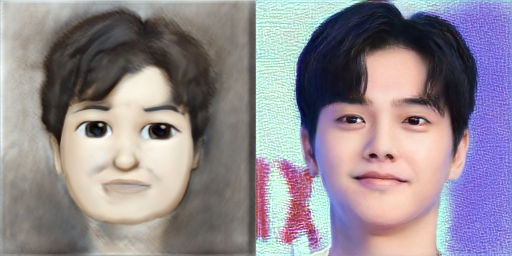

In [8]:
# Pick a seed and blend mask. The image will be saved in /content/ folder.

seed = 0 
blend = {
    '4':0,
    '8':0,
    '16':0.5,
    '32':0.5,
    '64':1,
    '128':1,
    '256':1,
}
psi = 1

bl_str = ('_').join([str(blend[o]) for o in blend])
net = net_tuned.split('/')[-1]
rnd = np.random.RandomState(seed)
z = torch.tensor(rnd.randn(1,G.z_dim)).cuda()
doBlend()
# w = G.mapping(z, None, truncation_psi=psi, truncation_cutoff=8)
projected_w = np.load("/content/drive/MyDrive/KHUDA_winter/out0121_2/projected_w.npz")
projected_w = projected_w['w']
w = torch.from_numpy(projected_w).to('cuda')
im1 = G.synthesis(w, noise_mode='random', force_fp32=True)
w_avg = G.mapping.w_avg  
w = w_avg + (w - w_avg) * psi
im3 = G_new.synthesis(w, noise_mode='random', force_fp32=True)
im1 = normalize(t2i(im1), 0.005)
im3 = normalize(t2i(im3),0.005)
im3.save("/content/drive/MyDrive/KHUDA_winter/out0122/memoji.jpg")
im = add_imgs([im3,im1])
im.save(f'/content/m{net}_sg2_norm_b{bl_str}_s{seed}.jpg'); im

In [ ]:
path = "/content/drive/MyDrive/KHUDA_winter/ffhq256-model/network-snapshot-001015.pkl"
with open(path, 'rb') as f:
  _G = pickle.load(f)
G_traing = _G["training_set_kwargs"]
G_G = _G["G"]
G_D = _G["D"]
G_augment = _G["augment_pipe"]
G_out = {"training_set_kwargs": G_traing, "G": G_G, "D": G_D, "G_ema": G_new ,"augment_pipe": G_augment}
with open("/content/drive/MyDrive/KHUDA_winter/ffhq256-model/out.pkl", 'wb') as f:
  pickle.dump(G_out, f)

print(_G)
print(G_out)
print(_G.keys())


{'training_set_kwargs': {'class_name': 'training.dataset.ImageFolderDataset', 'path': '/content/drive/MyDrive/KHUDA_winter/Memoji.zip', 'use_labels': False, 'max_size': 300, 'xflip': True, 'resolution': 256}, 'G': Generator(
  (synthesis): SynthesisNetwork(
    (b4): SynthesisBlock(
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b8): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b16): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b32): SynthesisBlock

In [ ]:
import training
from training import misc

model_1 = misc.load_pkl("/content/drive/MyDrive/KHUDA_winter/ffhq256-model/network-snapshot-001015.pkl")
print(model_1)

{'training_set_kwargs': {'class_name': 'training.dataset.ImageFolderDataset', 'path': '/content/drive/MyDrive/KHUDA_winter/Memoji.zip', 'use_labels': False, 'max_size': 300, 'xflip': True, 'resolution': 256}, 'G': Generator(
  (synthesis): SynthesisNetwork(
    (b4): SynthesisBlock(
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b8): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b16): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b32): SynthesisBlock

# Test models

Test all checkpoints in a folder

In [ ]:
import glob
checkpoint_folder = '/content/drive/MyDrive/deep_learning/arcane/training-runs/00002-stylegan2-notoned_noblur-256x256-gpus1-batch16-gamma6.6'
models = glob.glob(f'{checkpoint_folder}/**/*.pkl', recursive=True)

In [ ]:
from tqdm.notebook import trange
import os

psi=0.5
blend = {
    '4':0,
    '8':0,
    '16':0,
    '32':0,
    '64':0.5,
    '128':1,
    '256':0.7,
} #main

bl_str = ('_').join([str(blend[o]) for o in blend])

net = net_tuned.split('/')[-1]
doBlend()

for m in models:
  G_tuned = get_model(m)
  doBlend()
  out_dir = f"/content/m{m.split('/')[-1]}_sg2_norm_b{bl_str}"
  os.makedirs(out_dir, exist_ok=1)

  for i in trange(100):
    seed =i

    rnd = np.random.RandomState(seed)
    z = torch.tensor(rnd.randn(1,G.z_dim)).cuda()
    w1 = G.mapping(z, None, truncation_psi=psi, truncation_cutoff=8)

    im1 = G.synthesis(w1, noise_mode='const', force_fp32=True)
    im3 = G_new.synthesis(w1, noise_mode='const', force_fp32=True)

    im1 = t2i(im1)
    im3 = normalize(t2i(im3),0.005)

    im = add_imgs([im3,im1])
    im.save(f'{out_dir}/m{net}_sg2_norm_b{bl_str}_s{seed}.jpg'); im

In [ ]:
#archive results
!zip -r /content/tests_sg2_norm_b{bl_str}.zip /content/mnetwork-snapshot-000*.pkl_sg2_norm_b{bl_str} 

# Make dataset

In [ ]:
from tqdm.notebook import trange
import os

images = 2000
blend = {
    '4':0,
    '8':0,
    '16':0,
    '32':0,
    '64':0.5,
    '128':1,
    '256':0.7,
} #main
psi = 0.5

bl_str = ('_').join([str(blend[o]) for o in blend])
out_dir = f'/content/ds_m{net}_sg2_norm_b{bl_str}'
dir_a = f'{out_dir}/trainA'
dir_b = f'{out_dir}/trainB'

os.makedirs(out_dir, exist_ok=1)
os.makedirs(dir_a, exist_ok=1)
os.makedirs(dir_b, exist_ok=1)

net = net_tuned.split('/')[-1]
doBlend()

for i in trange(images):
  seed =i


  rnd = np.random.RandomState(seed)
  z = torch.tensor(rnd.randn(1,G.z_dim)).cuda()
  w = G.mapping(z, None, truncation_psi=psi, truncation_cutoff=8)

  im1 = G.synthesis(w, noise_mode='const', force_fp32=True)
  im3 = G_new.synthesis(w, noise_mode='const', force_fp32=True)

  im1 = t2i(im1)
  im3 = normalize(t2i(im3),0.005)

  im1.save(f'{dir_a}/{seed}.jpg')
  im3.save(f'{dir_b}/{seed}.jpg')

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
!zip -r /content/{out_dir}.zip /content/{out_dir}/*

# Upscale

In [ ]:
%cd /content/
!git clone https://github.com/sberbank-ai/Real-ESRGAN
%cd /content/Real-ESRGAN
!pip install -r requirements.txt
# download model weights
# x2 
!gdown https://drive.google.com/uc?id=1pG2S3sYvSaO0V0B8QPOl1RapPHpUGOaV -O weights/RealESRGAN_x2.pth


/content
Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 20 (delta 2), reused 17 (delta 2), pack-reused 0
Unpacking objects: 100% (20/20), done.
/content/Real-ESRGAN
Downloading...
From: https://drive.google.com/uc?id=1pG2S3sYvSaO0V0B8QPOl1RapPHpUGOaV
To: /content/Real-ESRGAN/weights/RealESRGAN_x2.pth
100% 67.1M/67.1M [00:00<00:00, 139MB/s] 


In [ ]:
from realesrgan import RealESRGAN
from PIL import Image
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

model = RealESRGAN(device, scale=2)
model.load_weights('weights/RealESRGAN_x2.pth')

def proc_img(path_to_image, result_image_path):
  image = Image.open(path_to_image).convert('RGB')
  sr_image = model.predict(np.array(image))
  sr_image.save(result_image_path)

device: cuda


In [ ]:
from glob import glob
from tqdm.notebook import tqdm

input_folder = '/content/ds_mnetwork-snapshot-000160.pkl_sg2_norm_b0_0_0_0_0.5_1_0.7'
output_folder = f'/content/{input_folder.split('/')[-1]}_upscaled'

imgs = glob(f'/{input_folder}/**/*', recursive=True)
for im in tqdm(imgs):
  proc_img(im,f'{output_folder}/{im.split('/')[-1]}')

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
!zip -qq /content/{output_folder}.zip /content/{output_folder}/**/*